# Logistic Regression - Affairs

We are going to use logistic regression to determine the likelihood of a married woman having an affair.

 Import modules and start exploring the dataset

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab
import scipy.stats as stats
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
%matplotlib inline 
mpl.style.available
mpl.style.use('ggplot') 

##Data 
Number of observations: 6366

Number of variables: 9

Variable name definitions:

    rate_marriage   : How rate marriage, 1 = very poor, 2 = poor, 3 = fair,
                    4 = good, 5 = very good
    age             : Age
    yrs_married     : No. years married. Interval approximations. See
                    original paper for detailed explanation.
    children        : No. children
    religious       : How relgious, 1 = not, 2 = mildly, 3 = fairly,
                    4 = strongly
    educ            : Level of education, 9 = grade school, 12 = high
                    school, 14 = some college, 16 = college graduate,
                    17 = some graduate school, 20 = advanced degree
    occupation      : 1 = student, 2 = farming, agriculture; semi-skilled,
                    or unskilled worker; 3 = white-colloar; 4 = teacher
                    counselor social worker, nurse; artist, writers;
                    technician, skilled worker, 5 = managerial,
                    administrative, business, 6 = professional with
                    advanced degree
    occupation_husb : Husband's occupation. Same as occupation.
    affairs         : measure of time spent in extramarital affairs

Load the data available in statmodels (http://statsmodels.sourceforge.net/stable/datasets/generated/fair.html)

In [3]:
df = sm.datasets.fair.load_pandas().data

In [4]:
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3,32,9.0,3,3,17,2,5,0.111111
1,3,27,13.0,3,1,14,3,4,3.230769
2,4,22,2.5,0,1,16,3,5,1.400000
3,4,37,16.5,4,3,16,5,5,0.727273
4,5,27,9.0,1,1,14,3,4,4.666666


In [5]:
df.columns

Index([u'rate_marriage', u'age', u'yrs_married', u'children', u'religious',
       u'educ', u'occupation', u'occupation_husb', u'affairs'],
      dtype='object')

Create a categorical label for affairs - from measure of time spent in extramarital affair to "affair"/"non affair". If somebody "spends any time" in an affair, this is counted as a yes or 1, otherwise it's a zero. We add a new column to the dataframe.

In [6]:
df['affair']=df['affairs'].map(lambda x: 1 if x>0 else 0)


In [7]:
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
0,3,32,9.0,3,3,17,2,5,0.111111,1
1,3,27,13.0,3,1,14,3,4,3.230769,1
2,4,22,2.5,0,1,16,3,5,1.400000,1
3,4,37,16.5,4,3,16,5,5,0.727273,1
4,5,27,9.0,1,1,14,3,4,4.666666,1


In [ ]:
df.affair.value_counts()

In [12]:
df.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


In [13]:
df.groupby('yrs_married').mean()

,rate_marriage,age,children,religious,educ,occupation,occupation_husb,affairs,affair
yrs_married,,,,,,,,,
0.5,4.524324,22.156757,0.048649,2.454054,14.237838,3.302703,3.502703,0.546486,0.043243
2.5,4.239921,23.640364,0.297198,2.312684,14.384956,3.383481,3.614061,0.984877,0.215831
6.0,4.066608,26.439089,1.036810,2.347064,14.454864,3.469763,3.881683,0.741184,0.339176
9.0,3.985050,28.985050,1.649502,2.368771,14.367110,3.393688,4.061462,0.737495,0.421927
13.0,4.038983,32.610169,1.916102,2.457627,14.218644,3.474576,4.100000,0.508149,0.411864
16.5,3.952323,35.135697,2.814181,2.601467,13.710269,3.415648,4.014670,0.484304,0.451100
23.0,3.956843,41.013564,3.281751,2.652281,13.794081,3.511714,4.051788,0.369099,0.425401


In [ ]:
df.groupby('rate_marriage').mean()

Exploring with plots

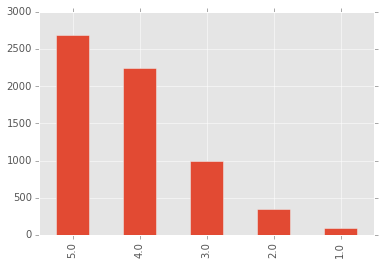

In [17]:
rating=df.rate_marriage.value_counts()
rating.plot(kind='bar')

In [18]:
table1=pd.crosstab(df.rate_marriage,df.affair)
table1

affair,0,1
rate_marriage,,
1,25,74
2,127,221
3,446,547
4,1518,724
5,2197,487


In [ ]:
table1.plot(kind='bar') 

In [ ]:
table2=pd.crosstab(df.yrs_married,df.affair)
table2

In [ ]:
table2.plot(kind='bar') 

# Logistic Regression

Some of the features, such as the age of a woman are more or less continuous (technically they are integer so not continuous because we don't have their 'exact' age but let's gloss over that). 

Other features such as a woman or her partner's occupation are categorical. If somebody has occupation type 2, that does not make their job "more" similar to somebody of job type 1 than job type 5. For that reason, this is generally dealt with by a feature engineering technique called making "dummy variables". The general idea is to get rid of a column which contains such categorical entries, and make new columns for each possible value. Because there are 6 possible occupations, this would result in making six columns labelled "Job 1" , "Job 2" etc. If somebody is in occupation 2, they get an entry of 1 in the "Job 2" column and 0 elsewhere.

The Patsy library used in this notebook to do this goes one step further and notes that as there are 6 occupations, we can get away with 5 columns because if all 5 job columns for one person are zero, they must have the sixth occupation. 

The synatx of patsy's dmatrices function is to denote features with a categorical with a C before them. Features which are continuous are just denoted by their name. The ~ between affair and the rest of the features denotes that affair is the target variable/label and everything subsequent are features.

In [19]:
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + religious + \
                   C(educ) + C(occupation) + C(occupation_husb)',
                  df, return_type="dataframe")
print X.columns


Index([u'Intercept', u'C(educ)[T.12.0]', u'C(educ)[T.14.0]',
       u'C(educ)[T.16.0]', u'C(educ)[T.17.0]', u'C(educ)[T.20.0]',
       u'C(occupation)[T.2.0]', u'C(occupation)[T.3.0]',
       u'C(occupation)[T.4.0]', u'C(occupation)[T.5.0]',
       u'C(occupation)[T.6.0]', u'C(occupation_husb)[T.2.0]',
       u'C(occupation_husb)[T.3.0]', u'C(occupation_husb)[T.4.0]',
       u'C(occupation_husb)[T.5.0]', u'C(occupation_husb)[T.6.0]',
       u'rate_marriage', u'age', u'yrs_married', u'children', u'religious'],
      dtype='object')


We are going to use Sci-kit learn's logistic regression library. Sci-kit learn's fit functions tend to take and (n_data_points x n_feat) array of feature readings and a (n_data_points x 1) array containing labels. Consequently, we convert X and y which are pandas object data types into numpy arrays.

In [20]:
X=np.array(X)
y=np.array(y)


print y


[[ 1.]
 [ 1.]
 [ 1.]
 ..., 
 [ 0.]
 [ 0.]
 [ 0.]]


Note there's a little problem here when we print y. It has been converted as a list of lists of length 1. It turns out that sci-kit learn is smart enough to deal with this, but it complains. In such cases, it's good practice to use numpy's ravel function. Ravel takes an array and "flattens" it. Example np.ravel([[1,2],[3,4,5]])=[1,2,3,4,5]

In this case, we are really only looking for np.ravel([[1],[1]])=[1,1]


Let's go ahead and run logistic regression on the entire data set, and see how accurate it is!

In [21]:
y=np.ravel(y)
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.7266729500471254

The model is able to correctly predict if somebody is having an affair 72.7% of the time. But how many people are actually having an affair? If 10% of all respondents are having an affair, then simply predicting that nobody is doing so will result in 90% accuracy. This is a case of what is known as the "accuracy paradox".

In [13]:
y.mean()

affair    0.322495
dtype: float64

You should have seen that 32.2% of respondents are having an affair, meaning that 67.8% is the baseline accuracy we need to beat for our model to have any predictive power. Indeed, 72.7% is substantially above this baseline and thus better than having no model at all. 

## Using a training and a test set.
Currently, we trained a model using all of the data available, then we (sci-kit learn's model.score function) looped back over the data and checked in how many cases the model correctly predicted whether that person was having an affair or not. This is somewhat prone to over fitting, as the data we are querying is already contained within the data the model was trained against. In a sense, the model has already seen these cases. A better test of model validity is the split the data into a training and a test set. Sci-kit learn has a nice function called train_test_split which splits data into test and training sets of user defined sizes, and does so selecting randomly from the global set (without replacement). 

The syntax is as follows: test_train_split(sample_to_split, test_size= , (optional kwargs))
The test size is a fraction so test_size=0.1 means the data will be split such that 10% of the total data set is in the test set and 90% in the training set.

test_train_split returns train_set,test_set in that order so standard syntax would be:

train_set,test_set=test_train_split(full_data_set,test_size=0.1) 

in order to get a 90/10 split.

test_train_split has a further nice quality, that it can split more than 1 array simultaneously and likewise do so correspondingly. This is most frequently useful when your features and labels are stored in different arrays, but of course you want to make sure that sets of corresponding feature and label data are pulled from the global data set. The syntax for splitting the features and labels into a training and test sets in a 70/30 split is shown below

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model = LogisticRegression(penalty='l2',C=100)
model.fit(X_train, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

Now for the test data, we predict its class (affair/no affair) for each set of feature values

In [26]:
predicted = model.predict(X_test)
print predicted

[ 1.  0.  0. ...,  0.  0.  0.]


Furthermore, sci-kit learn can tell us how sure it is of its predictions. Clearly for absolute predictions, if it thinks there is a 51% change of the woman in question having an affair, it still predicts affair. The predict_proba method on the other hand gives us this information in the format [probability of no affair, probability of affair] for every woman in the test set.

In [27]:
probs = model.predict_proba(X_test)
print probs

[[ 0.31677438  0.68322562]
 [ 0.92623403  0.07376597]
 [ 0.70499885  0.29500115]
 ..., 
 [ 0.61178678  0.38821322]
 [ 0.81995567  0.18004433]
 [ 0.72224891  0.27775109]]


##Accuracy
metrics.accuracy_score compares the test set's labels and the predicted values and divides the number which agree by the the total size of the test set

In [28]:
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.728272251309
0.743794892284


The accuracy is around 73%, which is the same as we experienced when training and predicting on the same data.


##Using Cross validatation
Cross validation involves performing the process of splitting into a test and training set multiple times to see whether the process itself is highly unstable. 

In [29]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
#add the kwarg n_jobs=-1 to run multiple cross-validations in parallel across all the cores available
#to you on your machine. Allegedly this doesn't always work in windows but should be fine on unix systems
print scores
print scores.mean()

[ 0.72413793  0.69435737  0.73824451  0.71226415  0.70597484  0.73427673
  0.71383648  0.70597484  0.75314465  0.75786164]
0.724007314525


## Predicting the Probability of an Affair

**Exercise** 

Just for fun, let's predict the probability of an affair for a random woman not present in the dataset. She's a 25-year-old teacher (occupation=4, see very top of notebook for a reminder) who graduated college (education=16), has been married for 3 years, has 1 child, rates herself as strongly religious, rates her marriage as fair (=3), and her husband is a farmer (occupation #2).

columns:
u'Intercept'
u'C(educ)[T.12.0]'
u'C(educ)[T.14.0]'
u'C(educ)[T.16.0]'
u'C(educ)[T.17.0]'
u'C(educ)[T.20.0]',
u'C(occupation)[T.2.0]'
u'C(occupation)[T.3.0]',
u'C(occupation)[T.4.0]'
u'C(occupation)[T.5.0]',
u'C(occupation)[T.6.0]'
u'C(occupation_husb)[T.2.0]'
u'C(occupation_husb)[T.3.0]'
u'C(occupation_husb)[T.4.0]'
u'C(occupation_husb)[T.5.0]'
u'C(occupation_husb)[T.6.0]'
u'rate_marriage'
u'age'
u'yrs_married'
u'children'
u'religious'

In [30]:
sample = np.array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 3, 25, 3, 1, 4])

p = model.predict_proba(sample)
print p

[[ 0.91612508  0.08387492]]


Would you like to estimate the probability of an affair of a person you know? :)